# Portugal Hotels Booking Demand

# Summary

This jupyter notebook has one dataset that has two different hotels from Portugal. This data will be analyzed to find any trends or patterns with guests booking into either hotel to try and find a way to minimize the amount of canceled bookings. A machine learning model will also be developed to attempt at predicting if a guest will cancel there booking before checking in.

There is a resort hotel in this dataset, found in the Algarve region of Portugal (southern Portugal), and a city hotel found in the captial Lisbon. Data was acquired directly from hotel's Property Managment System (PMS) SQL according to the paper which the data is originally from. The article is called, "Hotel Booking Demand Datasets", written by Nuno Antonio, Ana Almeida, and Luis Nunes for Data in Brief, Volume 22, February 2019. Found at https://www.sciencedirect.com/science/article/pii/S2352340918315191#bib5.

Dataset can also be found on Kaggle at https://www.kaggle.com/jessemostipak/hotel-booking-demand

## Import Python Librarys and Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from matplotlib import rcParams
rcParams['figure.figsize'] = 10,8
sns.set_theme()

## Reading and cleaning data

In [2]:
df = pd.read_csv('hotel_bookings.csv')

In [3]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

We can see above there are many columns with missing values, and this will be addressed below

---

In [15]:
df['country'].isna().value_counts()

False    118902
True        488
Name: country, dtype: int64

Dropping the agent column entirely since it only has a integer value for the listing agent and no information about the company the agent works for or the country of origin for the agency.

There were 4 four rows with NaN value in the column 'children' and it has been assumed that these rooms did not have any children and a value of zero has been put there it its place. Its dtype was then converted to 'int64'.

Any rows that did not have a country of origin has been dropped as this seems to be questionable data (though these guests could likely be from Portugal and simpy did not enter their country of origin). There were only 488 rows dropped.

One row has a value for 'adr' greater than 4000. This means the average daily rate as defined by dividing the sum of all lodging transactions by the total number of staying nights was greater than €4,000. This is only on one row  and has been dropped since it is an extreme outlier.

Some rooms did not have any adults or children registered for that booking, and is likely some data had been incomplete when being filled in, same with rows that did not have a country of origin.

Lastly, all null values for 'company' column has been filled in with integer value zero.

In [6]:
df.drop('agent', axis=1, inplace=True)
df.loc[(df[df['children'].isna()].index.values),'children'] = 0
df.children = df.children.astype('int64')
df.drop(df[df['country'].isna()].index.values,axis=0, inplace=True)

df.drop(df[df['adr'] > 4000].index.values,axis=0, inplace=True) # add to note above
df.drop(df[df['adults']==0].index.values,axis=0, inplace=True)
df['company'].fillna(value=0,inplace=True)

# EDA & Visualizing hotel data

We will begin by talking about each column in more depth:

* **hotel**- Either resort hotel, Algarve, or City hotel, Lisbon.  
* **is_canceled**- If a guest has cancelled a booking or not before checking into a hotel, value of 1 or 0 respectively.  
* **lead_time**- The day a guest made their booking, ie number of days before guest is expected to arrive.  
* **arrive_date_year**- The year the guest is expected to arrive at a hotel, from 2016-2017.  
* **arrival_date_month**- The month of the year the guest is expected to arrive at a hotel.  
* **arrival_date_week_number**- The week number (52 weeks in a year) the guest is expected to arrive at a hotel. 
* **arrival_date_day_of_month**- The day of the month the guest is expected to arrive at a hotel.  
* **stays_in_weekend_nights**- The number of nights the guest is going to stay during the weekend.  
* **stays_in_week_nights**- The number of nigths the guest is going to stay during the week.  
* **adults**- Number of adults booked to stay in the room for the duration of their time in the hotel.  
* **children**- Number of children booked to stay in the room for the duration of their time in the hotel.  
* **babies**- Number of babies booked to stay in a room for the duration of their time in the hotel.  
* **meal**- Type of meal booked. Categories are presented in standard hospitality meal packages: 
    * Undefined/SC – no meal package  
    * BB – Bed & Breakfast  
    * HB – Half board (breakfast and one other meal – usually dinner)  
    * FB – Full board (breakfast, lunch and dinner)  
* **country**- Country of origin. Categories are represented in the ISO 3155–3:2013 format.  
* **market_segment**- Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators”.  
* **distribution_channel**-Booking distribution channel. The term “TA” means “Travel Agents” and “TO” means “Tour Operators”.  
* **is_repeated_guest**- Value indicating if the booking name was from a repeated guest (1) or not (0).  
* **previous_cancellations**- Number of previous bookings that were cancelled by the customer prior to the current booking.  
* **previous_bookings_not_canceled**- Number of previous bookings not cancelled by the customer prior to the current booking.  
* **reserved_room_type**- Code of room type reserved. Code is presented instead of designation for anonymity reasons.  
* **assigned_room_type**- Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. Code is presented instead of designation for anonymity reasons.  
* **booking_changes**- Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation.  
* **deposit_type**- Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories:  
    * No Deposit – no deposit was made  
    * Non Refund – a deposit was made in the value of the total stay cost  
    * Refundable – a deposit was made with a value under the total cost of stay. 
* **agent**- ID of the travel agency that made the booking.  
* **company**- ID of the company/entity that made the booking or responsible for paying the booking. ID is presented instead of designation for anonymity reasons.  
* **days_in_waiting_list**- Number of days the booking was in the waiting list before it was confirmed to the customer.  
* **customer_type**- Type of booking, assuming one of four categories:
    * Contract - when the booking has an allotment or other type of contract associated to it
    * Group – when the booking is associated to a group
    * Transient – when the booking is not part of a group or contract, and is not associated to other transient booking  
    * Transient-party – when the booking is transient, but is associated to at least other transient booking  
* **adr**- Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights.  
* **required_car_parking_spaces**- Number of car parking spaces required by the customer.
* **total_of_special_requests**- Number of special requests made by the customer (e.g. twin bed or high floor).  
* **reservation_status**- Reservation last status, assuming one of three categories:  
    * Canceled – booking was canceled by the customer
    * Check-Out – customer has checked in but already departed
    * No-Show – customer did not check-in and did inform the hotel of the reason why  
* **reservation_status_date**- Date at which the last status was set. This variable can be used in conjunction with the ReservationStatus to understand when was the booking canceled or when did the customer checked-out of the hotel

## Resort & City Hotel

Below we see in figure 1 that there are many more city hotel bookings then there are resort hotel bookings in this dataset.

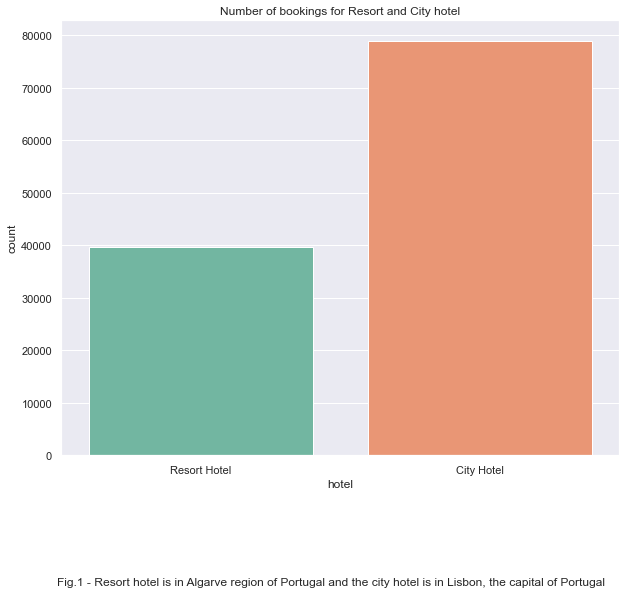

In [8]:
sns.countplot(x='hotel', data=df, palette='Set2');
plt.title('Number of bookings for Resort and City hotel')
txt_1='Fig.1 - Resort hotel is in Algarve region of Portugal and the city hotel is in Lisbon, the capital of Portugal'
plt.figtext(0.5, -0.1, txt_1, wrap=True, horizontalalignment='center', fontsize=12);

In [32]:
round(df['is_canceled'].value_counts()[1]/df['is_canceled'].value_counts()[0],4)*100

58.84

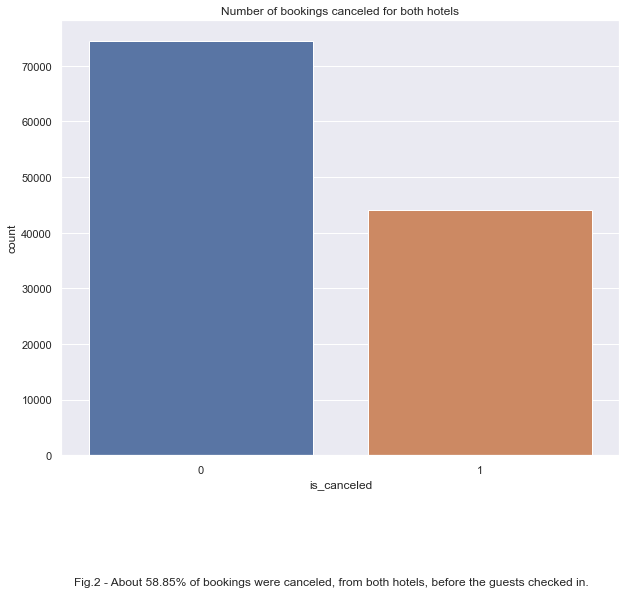

In [10]:
sns.countplot(x='is_canceled', data=df);
plt.title('Number of bookings canceled for both hotels')
txt_2='Fig.2 - About 58.85% of bookings were canceled, from both hotels, before the guests checked in.'
plt.figtext(0.5, -0.1, txt_2, wrap=True, horizontalalignment='center', fontsize=12);

In [53]:
round(df[df['hotel'] == 'City Hotel']['is_canceled'].value_counts()[1]/df[df['hotel'] == 'City Hotel']['is_canceled'].value_counts()[0],4)*100

71.61

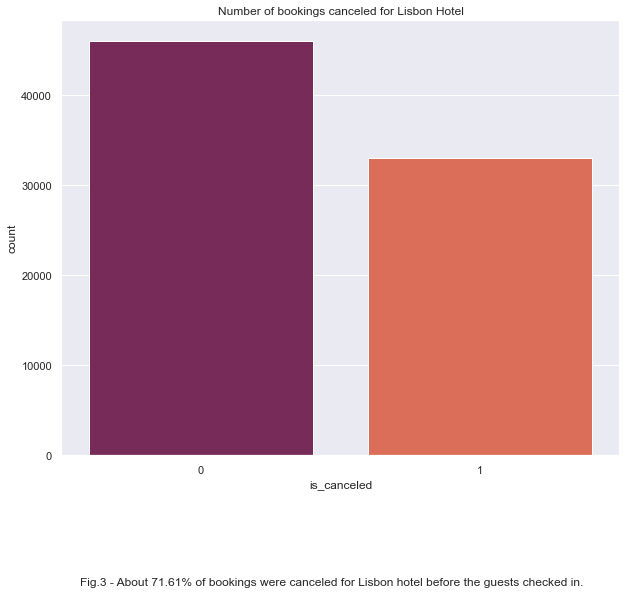

In [9]:
sns.countplot(x='is_canceled', data=df[df['hotel'] == 'City Hotel'], palette='rocket');
plt.title('Number of bookings canceled for Lisbon Hotel')
txt_3='Fig.3 - About 71.61% of bookings were canceled for Lisbon hotel before the guests checked in.'
plt.figtext(0.5, -0.1, txt_3, wrap=True, horizontalalignment='center', fontsize=12);

In [56]:
round(df[df['hotel'] == 'Resort Hotel']['is_canceled'].value_counts()[1]/df[df['hotel'] == 'Resort Hotel']['is_canceled'].value_counts()[0],4)*100

38.43

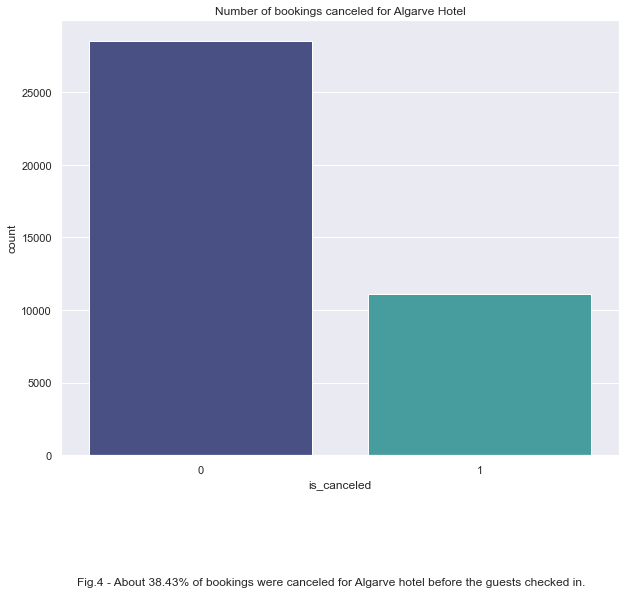

In [12]:
sns.countplot(x='is_canceled', data=df[df['hotel'] == 'Resort Hotel'], palette='mako');
plt.title('Number of bookings canceled for Algarve Hotel')
txt_4='Fig.4 - About 38.43% of bookings were canceled for Algarve hotel before the guests checked in.'
plt.figtext(0.5, -0.1, txt_4, wrap=True, horizontalalignment='center', fontsize=12);

Most of the bookings for this dataset are from the city hotel (Lisbon) which also has a higher chance of a guest canceling before they check in at 71.61%, where as the resort hotel (Algarve) only has around 38.43% chance of a guest canceling there booking. This suggests most people are looking around at multiple hotels to stay at in a city, but slightly more committed to pulling trigger for a resort hotel. That being said we would need more hotels from cities and then more resort hotels to confirm this theory.

### Countries Analysis

Now we will investigate what country has the most guests booking rooms, and if some countries guests are more likely to cancel.

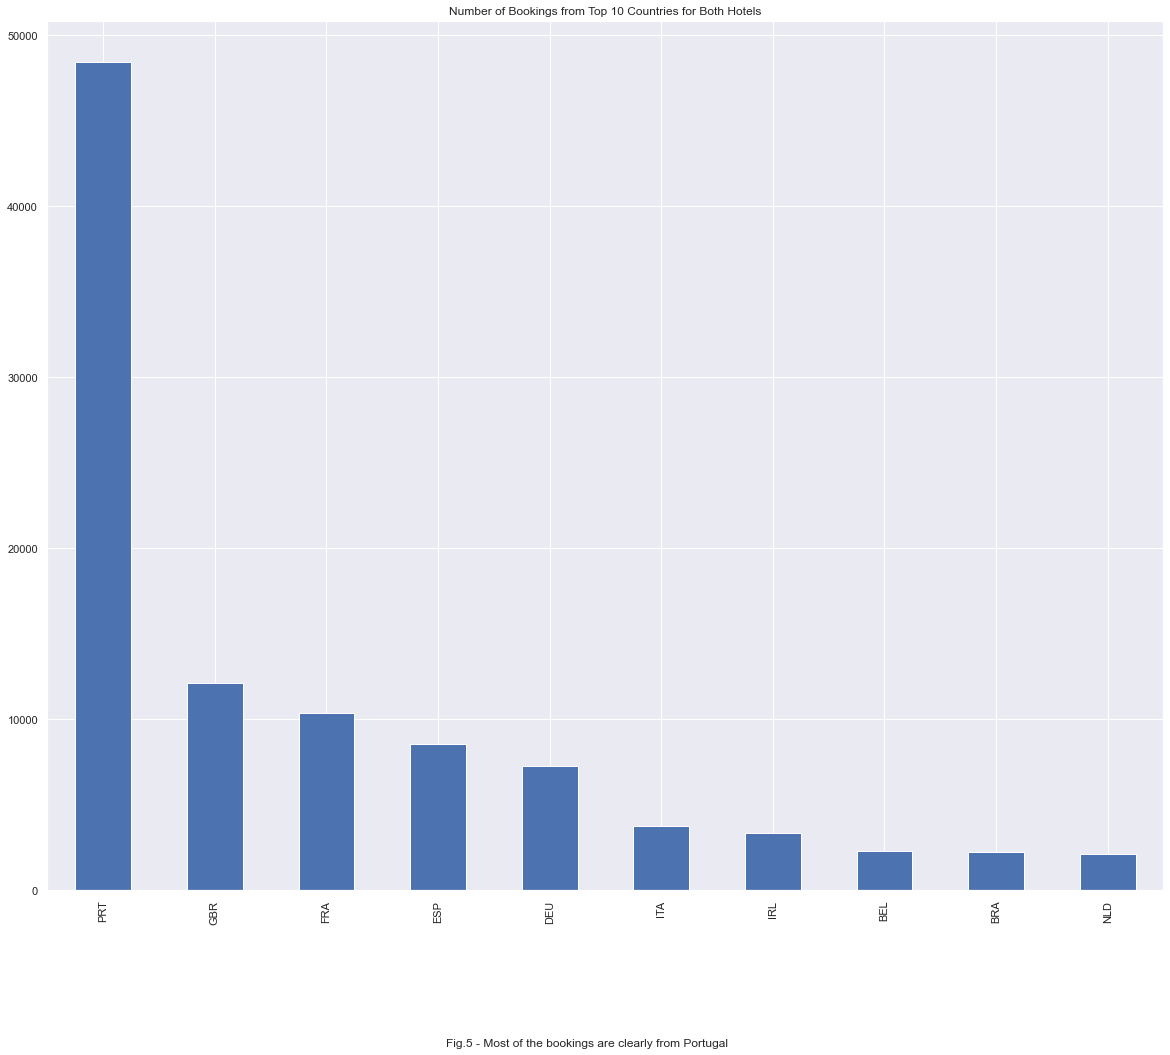

In [33]:
df['country'].value_counts().head(10).plot.bar();
plt.title('Number of Bookings from Top 10 Countries for Both Hotels')
txt_5='Fig.5 - Most of the bookings are clearly from Portugal'
plt.figtext(0.5, -0.01, txt_5, wrap=True, horizontalalignment='center', fontsize=12);

We can see in Figure 5 that most guests are coming from this host country, Portugal, at 56.76%. Only one country is on the list that is not in Europe and that is Brazil.

In [128]:
tmp = df.groupby('country')['is_canceled'].sum()/df.groupby('country')['is_canceled'].count()
tmp.sort_values(ascending=False).loc[df['country'].value_counts().head(10).index.values]

country
PRT    0.567580
GBR    0.202313
FRA    0.185813
ESP    0.254271
DEU    0.167102
ITA    0.353945
IRL    0.246291
BEL    0.202494
BRA    0.372514
NLD    0.182426
Name: is_canceled, dtype: float64

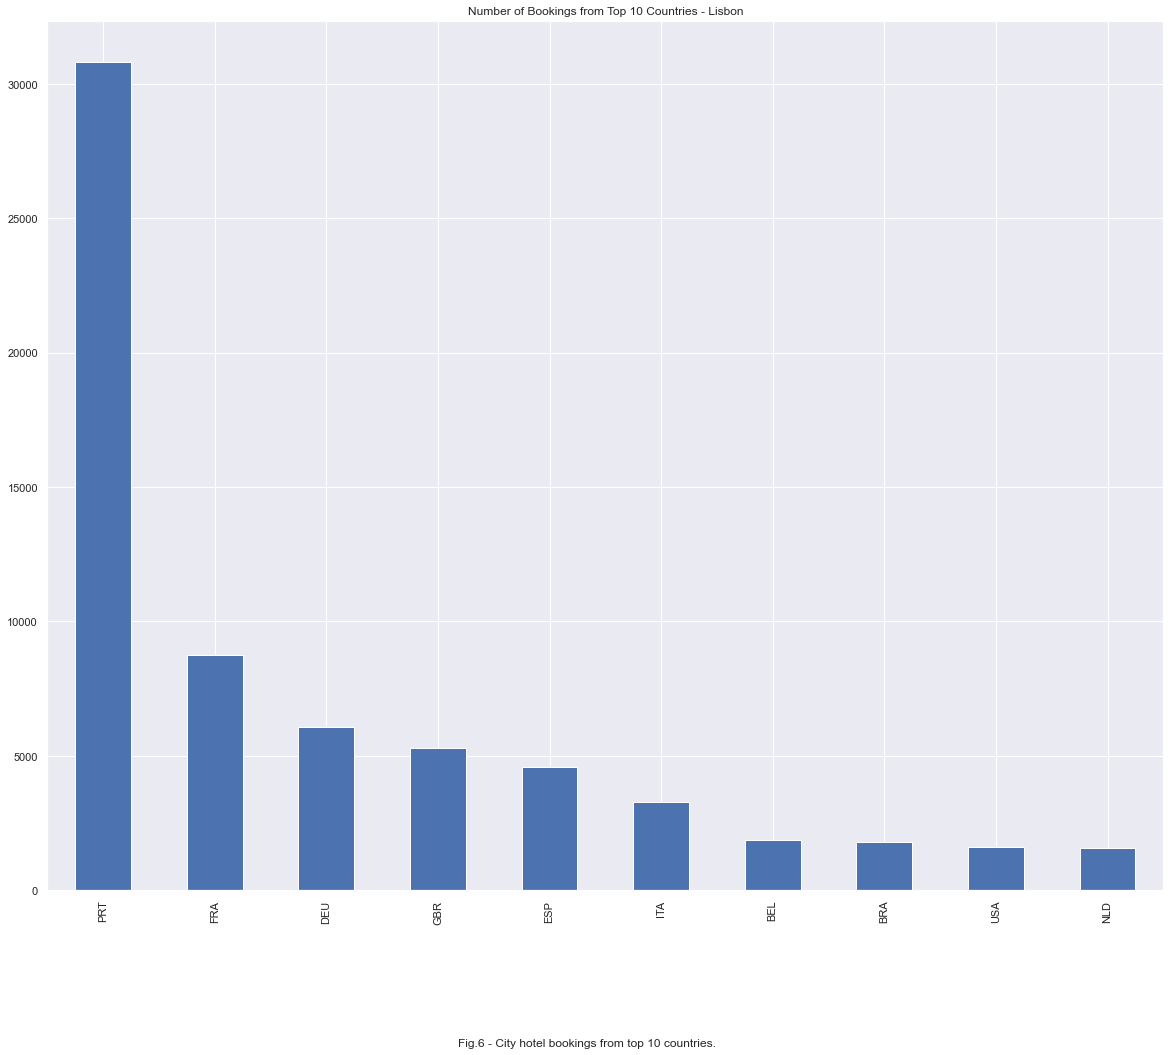

In [32]:
df[df['hotel'] == 'City Hotel']['country'].value_counts().head(10).plot.bar();
plt.title('Number of Bookings from Top 10 Countries - Lisbon')
txt_6='Fig.6 - City hotel bookings from top 10 countries.'
plt.figtext(0.5, -0.01, txt_6, wrap=True, horizontalalignment='center', fontsize=12);

We can see in Figure 6 that most guests are also from Portugal when staying in Lisbon.

In [145]:
tmp = df[df['hotel'] == 'City Hotel'].copy()
tmp_ = tmp.groupby('country')['is_canceled'].sum()/tmp.groupby('country')['is_canceled'].count()
tmp_.sort_values(ascending=False).loc[tmp['country'].value_counts().head(10).index.values]

country
PRT    0.650777
FRA    0.195870
DEU    0.176170
GBR    0.294407
ESP    0.288017
ITA    0.378986
BEL    0.219382
BRA    0.405724
USA    0.264633
NLD    0.206329
Name: is_canceled, dtype: float64

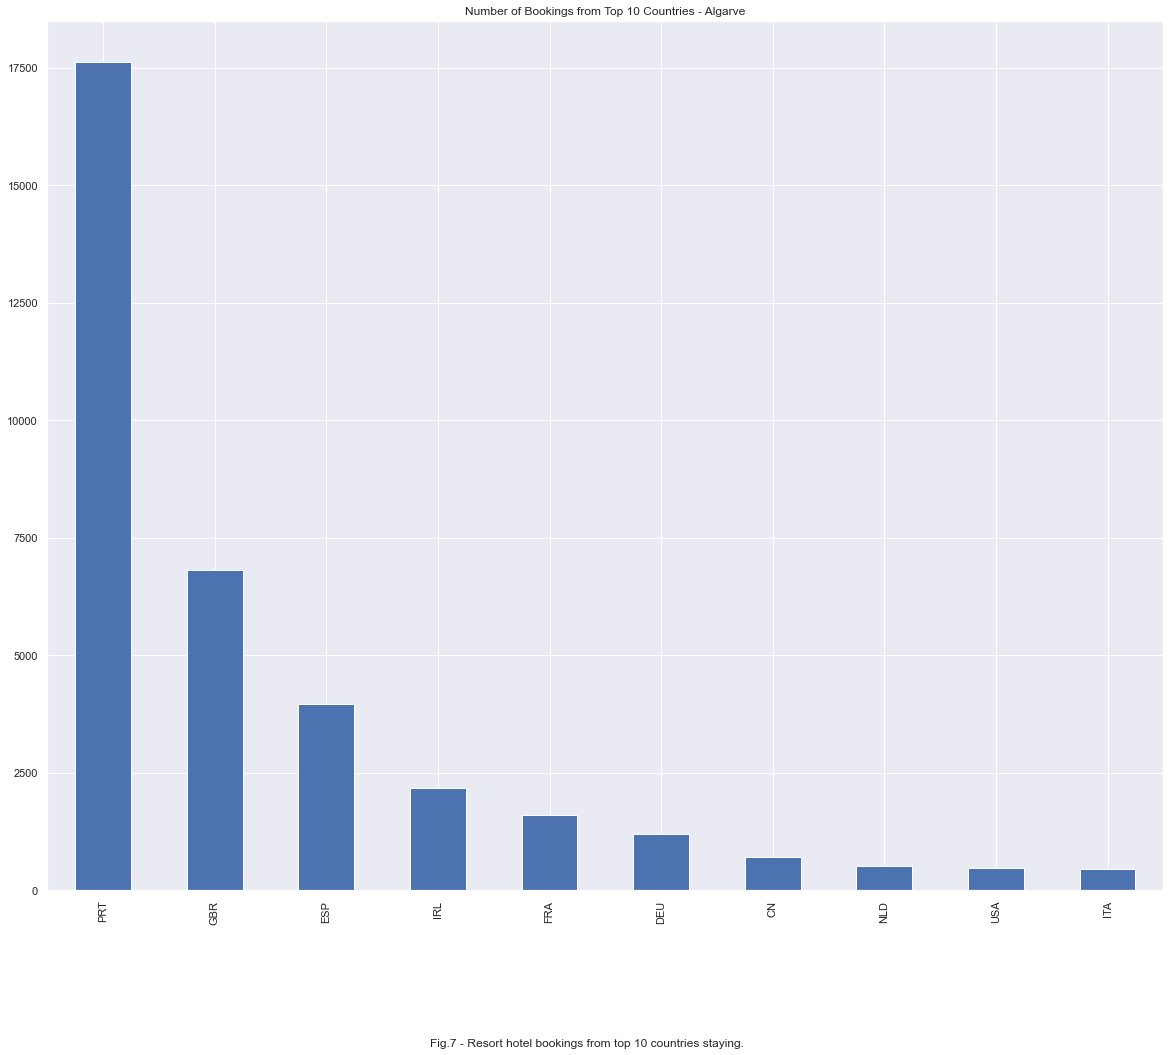

In [31]:
df[df['hotel'] == 'Resort Hotel']['country'].value_counts().head(10).plot.bar();
plt.title('Number of Bookings from Top 10 Countries - Algarve')
txt_7='Fig.7 - Resort hotel bookings from top 10 countries staying.'
plt.figtext(0.5, -0.01, txt_7, wrap=True, horizontalalignment='center', fontsize=12);

We can see in Figure 6 that most guests are also from Portugal when staying in Lisbon.

In [146]:
tmp = df[df['hotel'] == 'Resort Hotel'].copy()
tmp_ = tmp.groupby('country')['is_canceled'].sum()/tmp.groupby('country')['is_canceled'].count()
tmp_.sort_values(ascending=False).loc[tmp['country'].value_counts().head(10).index.values]

country
PRT    0.422086
GBR    0.130779
ESP    0.215116
IRL    0.199446
FRA    0.131056
DEU    0.121363
CN     0.135211
NLD    0.108949
USA    0.150313
ITA    0.174292
Name: is_canceled, dtype: float64

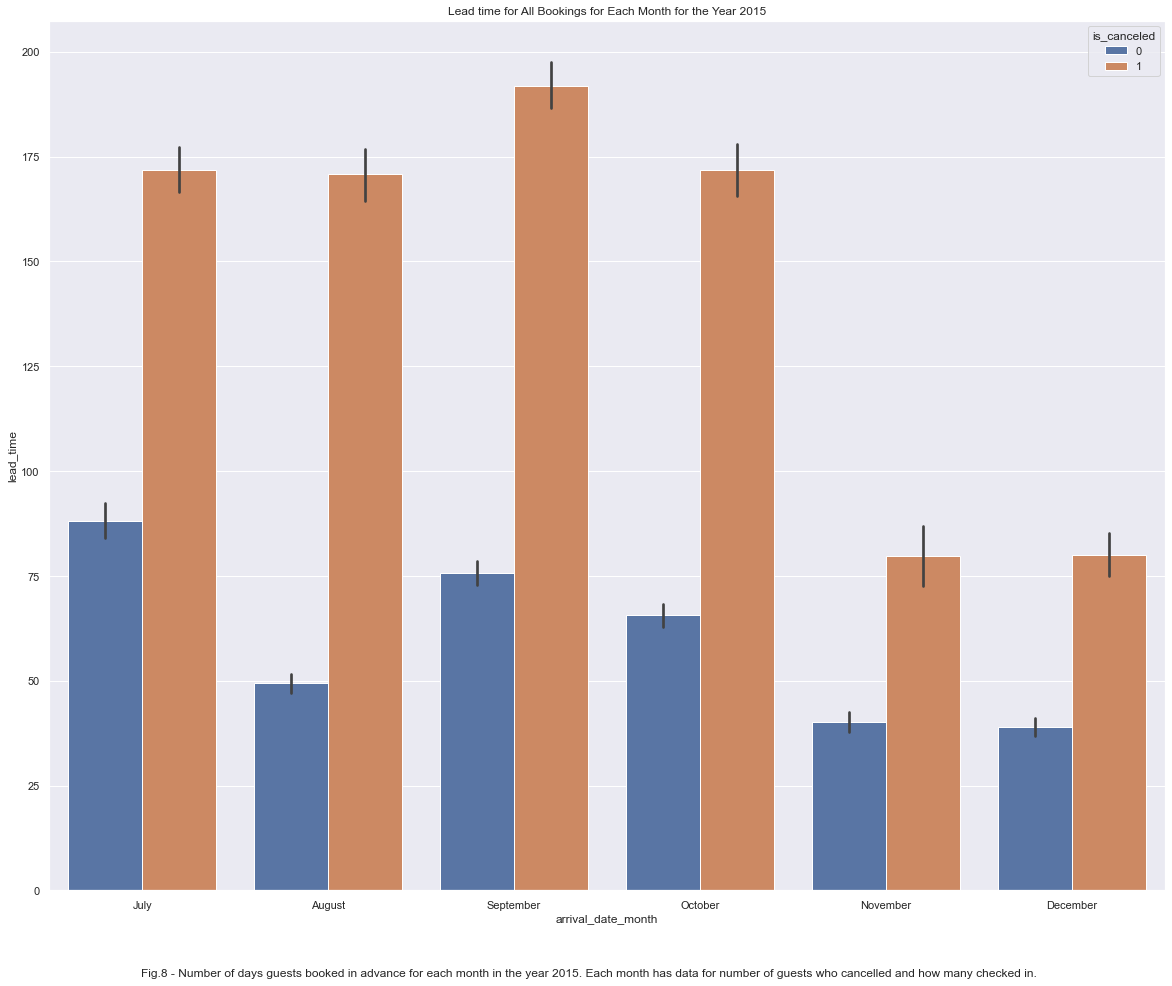

In [34]:
sns.set(rc={'figure.figsize':(20,16)})
df_tmp = df[df['arrival_date_year'] == 2015]
sns.barplot(x='arrival_date_month',y='lead_time',hue='is_canceled',data=df_tmp);
plt.title('Lead time for All Bookings for Each Month for the Year 2015')
txt_8='Fig.8 - Number of days guests booked in advance for each month in the year 2015. Each month has data for number of guests who cancelled and how many checked in.'
plt.figtext(0.5, 0.05, txt_8, wrap=True, horizontalalignment='center', fontsize=12);

In [55]:
df_tmp.groupby('arrival_date_month')[['is_canceled','lead_time']].mean().sort_values(by='is_canceled', ascending=False)

,is_canceled,lead_time
arrival_date_month,,
July,0.455664,126.365545
August,0.412174,99.364457
September,0.408733,123.068253
October,0.348851,102.595650
December,0.335517,52.683793
November,0.209483,48.476724


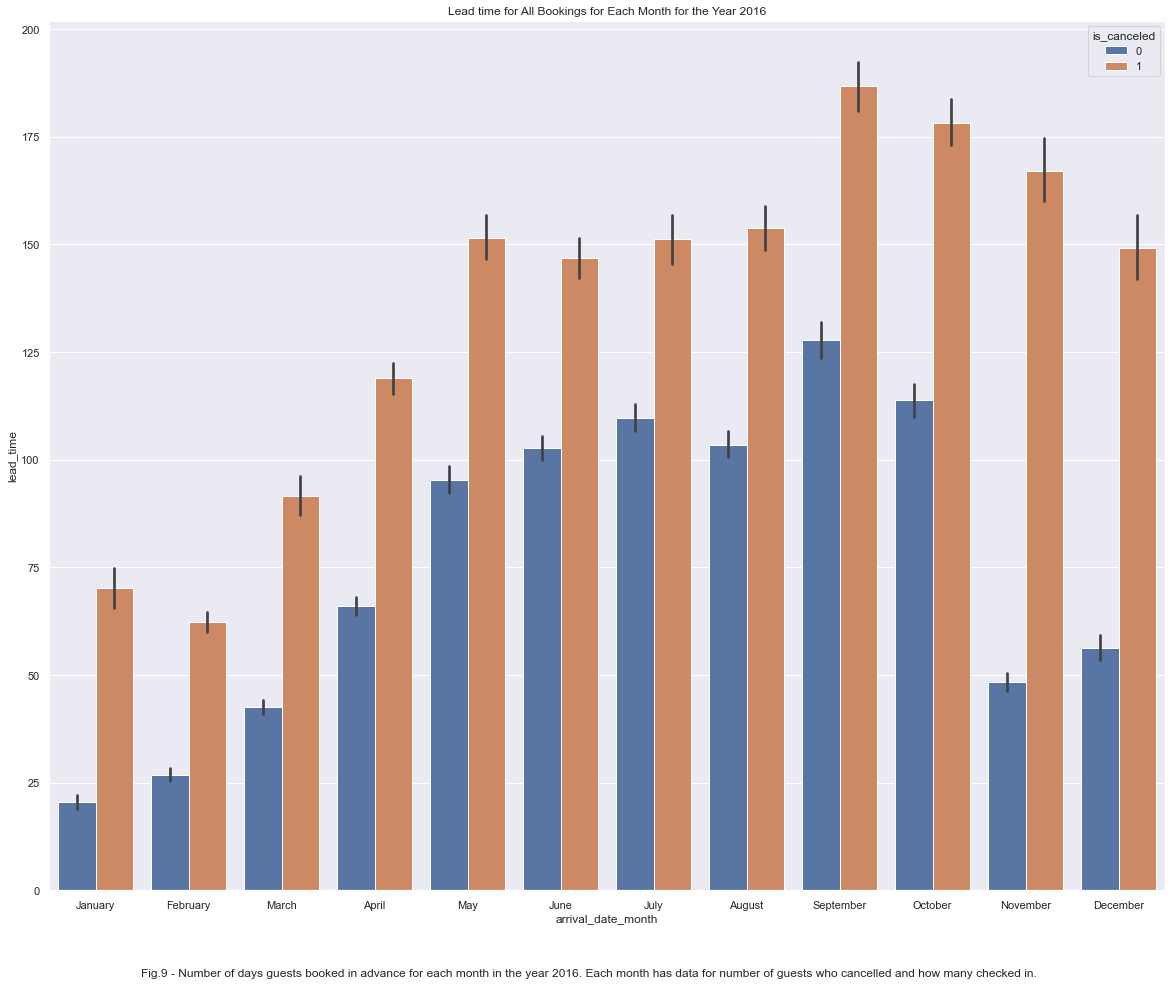

In [35]:
df_tmp = df[df['arrival_date_year'] == 2016]
sns.barplot(x='arrival_date_month',y='lead_time',hue='is_canceled',data=df_tmp);
plt.title('Lead time for All Bookings for Each Month for the Year 2016')
txt_9='Fig.9 - Number of days guests booked in advance for each month in the year 2016. Each month has data for number of guests who cancelled and how many checked in.'
plt.figtext(0.5, 0.05, txt_9, wrap=True, horizontalalignment='center', fontsize=12);

In [43]:
df_tmp.groupby('arrival_date_month')[['is_canceled','lead_time']].mean().sort_values(by='is_canceled', ascending=False)

,is_canceled,lead_time
arrival_date_month,,
October,0.406736,140.018620
June,0.396780,120.053409
April,0.381014,86.188379
September,0.375627,149.689578
November,0.368682,91.964350
December,0.363114,90.105016
August,0.360902,121.638306
May,0.350348,114.914197
February,0.346383,39.144672


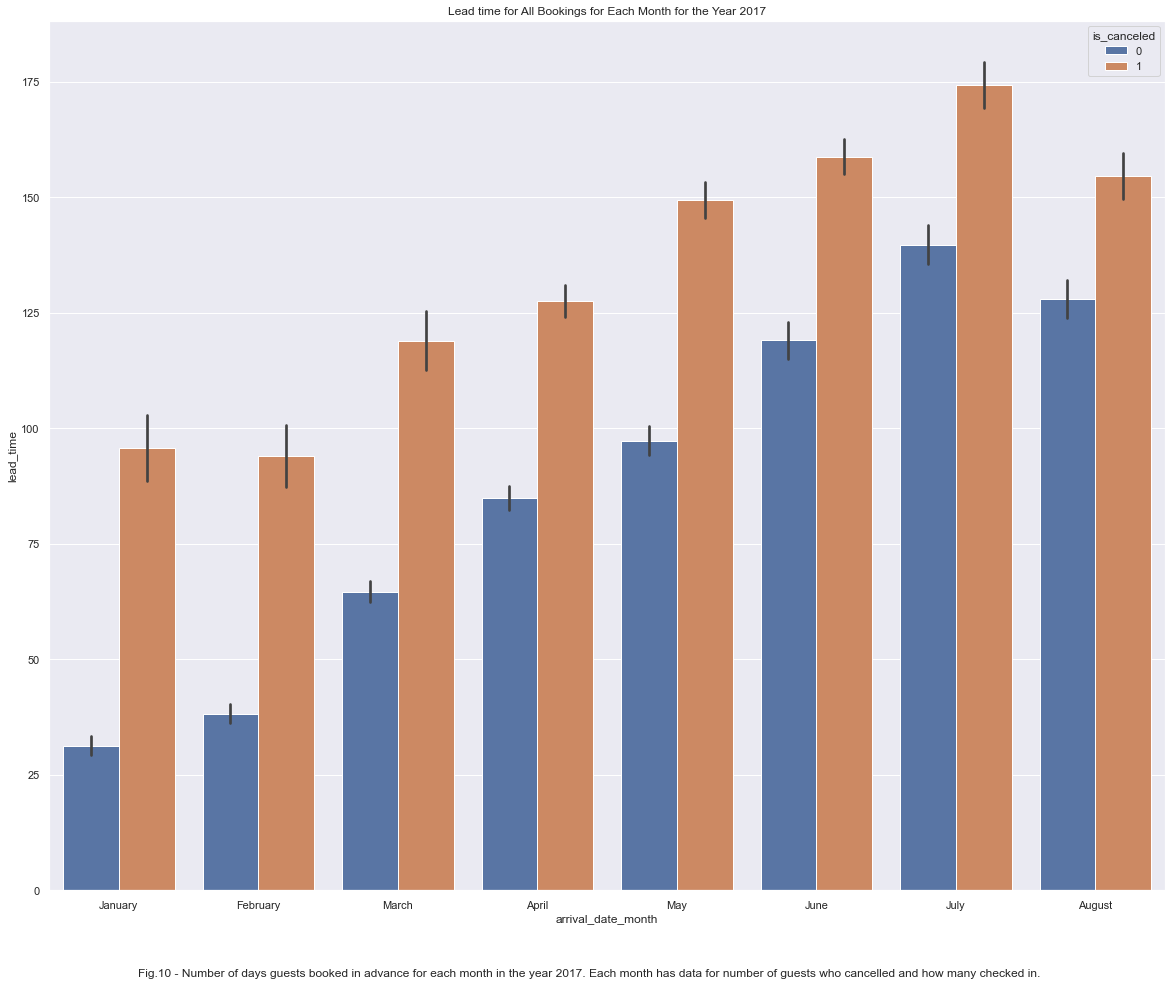

In [36]:
df_tmp = df[df['arrival_date_year'] == 2017]
sns.barplot(x='arrival_date_month',y='lead_time',hue='is_canceled',data=df_tmp);
plt.title('Lead time for All Bookings for Each Month for the Year 2017')
txt_10='Fig.10 - Number of days guests booked in advance for each month in the year 2017. Each month has data for number of guests who cancelled and how many checked in.'
plt.figtext(0.5, 0.05, txt_10, wrap=True, horizontalalignment='center', fontsize=12);

In [41]:
df_tmp.groupby('arrival_date_month')[['is_canceled','lead_time']].mean().sort_values(by='is_canceled', ascending=False)

,is_canceled,lead_time
arrival_date_month,,
May,0.437510,120.224933
April,0.434852,103.667789
June,0.431911,136.141491
July,0.373424,152.974026
August,0.368731,137.798579
January,0.341350,53.410768
March,0.337710,82.825288
February,0.327076,56.514801


In [20]:
first_year = len(df[df['arrival_date_year'] == 2015])
second_year = len(df[df['arrival_date_year'] == 2016])
third_year = len(df[df['arrival_date_year'] == 2017])

print('Number of guests who stayed in either hotel is {}, in the year 2015'.format(first_year))
print('Number of guests who stayed in either hotel is {}, in the year 2016'.format(second_year))
print('Number of guests who stayed in either hotel is {}, in the year 2017'.format(third_year))

Number of guests who stayed in either hotel is 21863, in the year 2015
Number of guests who stayed in either hotel is 56435, in the year 2016
Number of guests who stayed in either hotel is 40604, in the year 2017


The data is not equally distributed throughout the years, and we note in the plots above that year 2016 is the only year with data from all 12 months. 

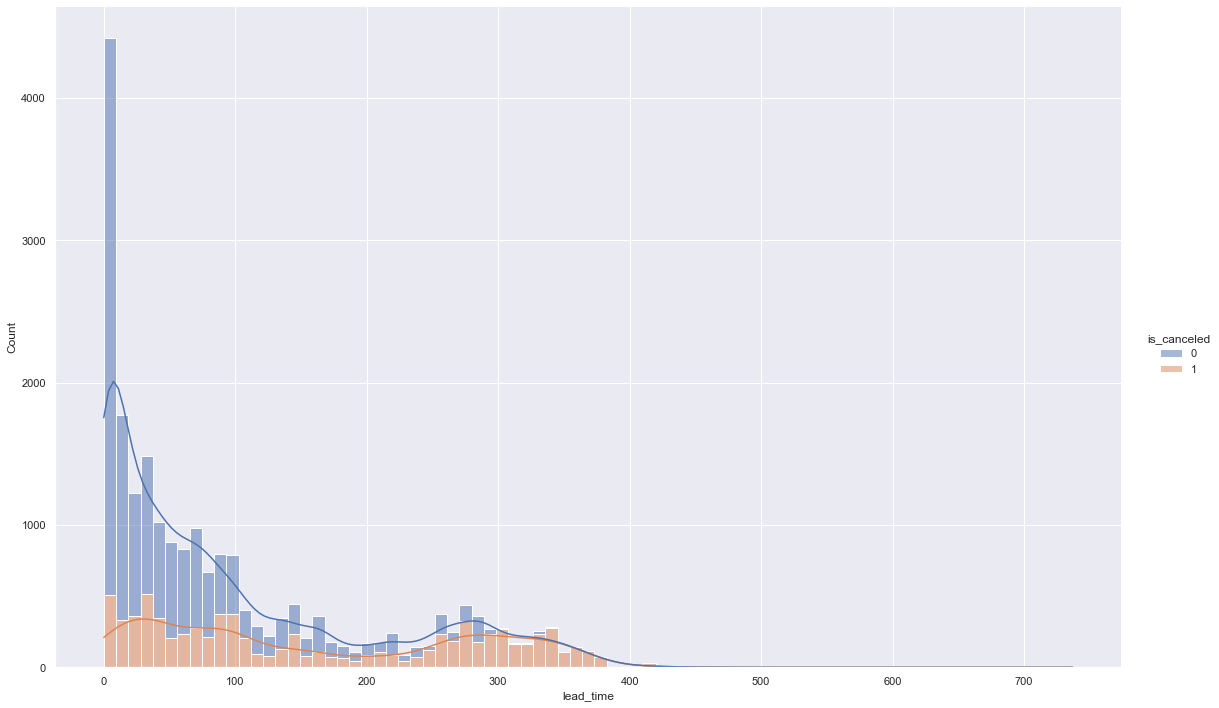

In [21]:
sns.displot(x='lead_time', hue='is_canceled', multiple="stack", kde=True, data=df[df['arrival_date_year'] == 2015], height=10, aspect=16/10);

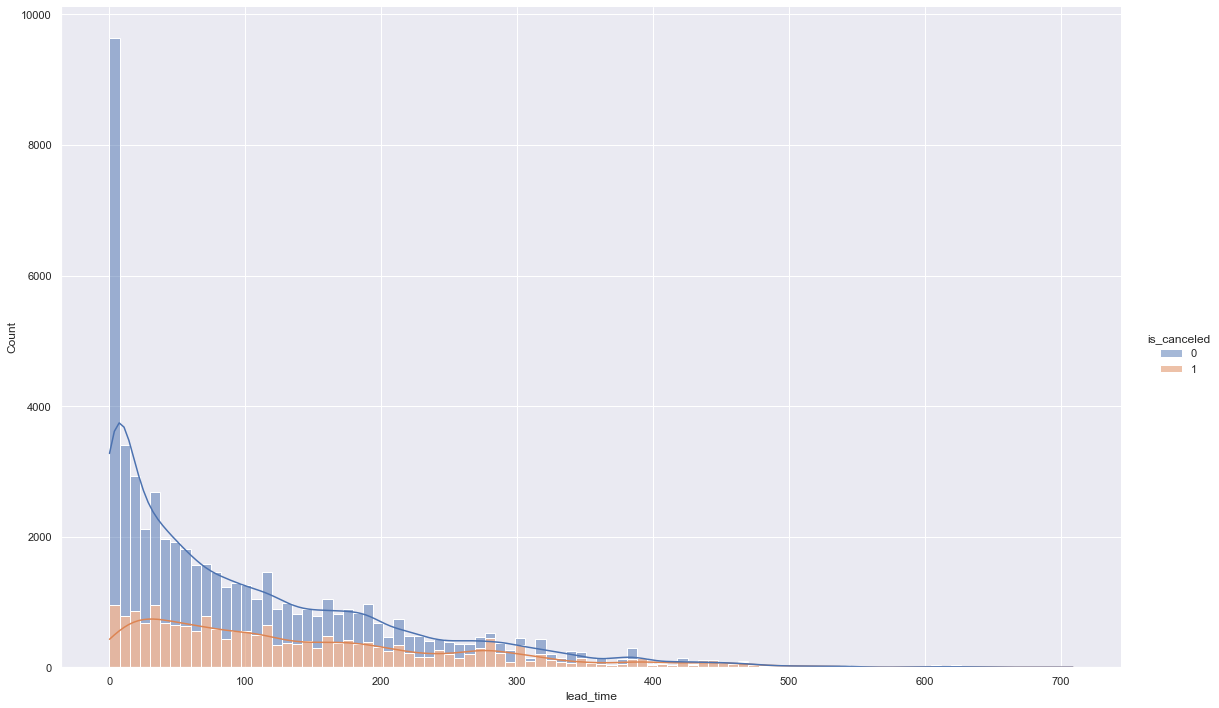

In [22]:
sns.displot(x='lead_time', hue='is_canceled', multiple="stack", kde=True, data=df[df['arrival_date_year'] == 2016], height=10, aspect=16/10);

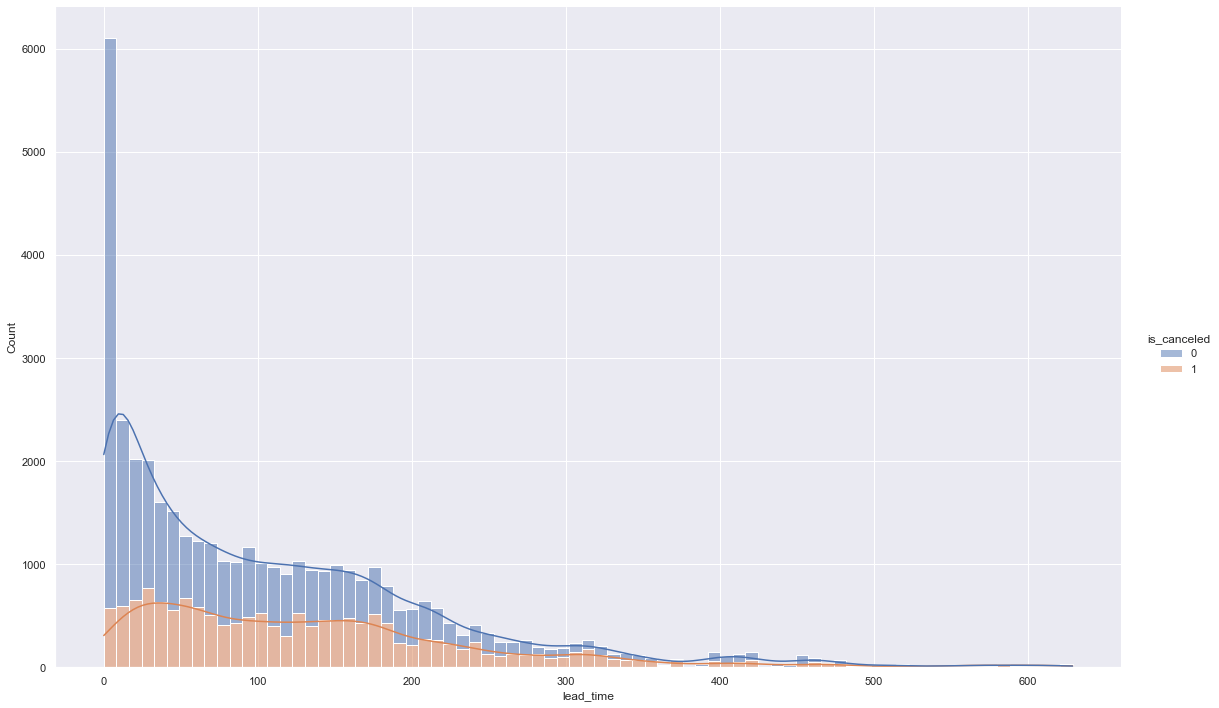

In [23]:
sns.displot(x='lead_time', hue='is_canceled', multiple="stack", kde=True, data=df[df['arrival_date_year'] == 2017], height=10, aspect=16/10);

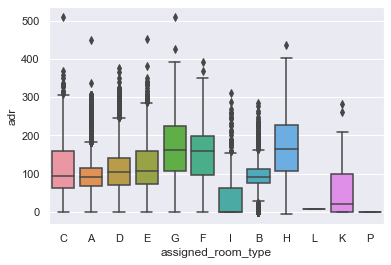

In [39]:
sns.boxplot(x='assigned_room_type',y='adr',data=df);

In [66]:
df_adr = df.copy()

In [67]:
df_adr['adr_adj'] = df_adr['adr']/(df_adr['adults']+df_adr['children'])
df_adr['adr_adj_wb'] = df_adr['adr']/(df_adr['adults']+df_adr['children']+df_adr['babies'])

df_adr.drop(df_adr[df_adr['adr_adj']>400].index.values,axis=0,inplace=True)

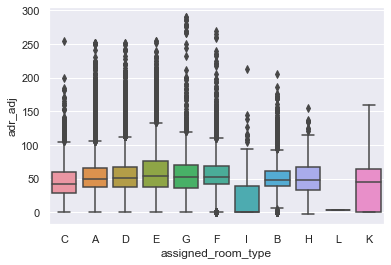

In [68]:
sns.boxplot(x='assigned_room_type',y='adr_adj',data=df_adr);

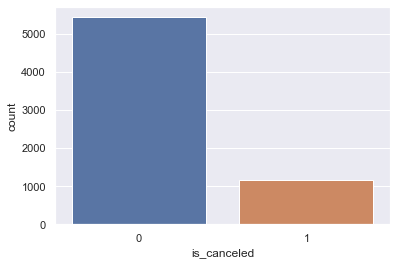

In [83]:
sns.countplot(data=df[~df['company'].isna()], x="is_canceled")

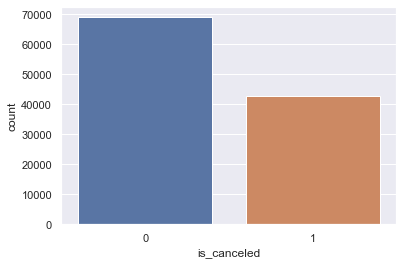

In [84]:
sns.countplot(data=df[df['company'].isna()], x="is_canceled")

In [97]:
df[~df['company'].isna()].is_canceled.value_counts() #show guests staying on behalf of a company or organization

0    5435
1    1167
Name: is_canceled, dtype: int64

In [112]:
x = df[~df['company'].isna()].is_canceled.value_counts()[1]/df[~df['company'].isna()].is_canceled.value_counts()[0]
round(x*100,2)

21.47

We see above that only 21.47% of guests cancel when they register with a company or organization.

In [98]:
df[df['company'].isna()].is_canceled.value_counts() #guests on vacation

0    69016
1    42890
Name: is_canceled, dtype: int64

In [111]:
x = df[df['company'].isna()].is_canceled.value_counts()[1]/df[df['company'].isna()].is_canceled.value_counts()[0]
round(x*100,2)

62.15

When a guest is booking to stay for a personal vaction they have a 62.15% of canceling a reservation.

## Dummy Variables

In [200]:
df_columns = ['hotel','arrival_date_month','meal','country','market_segment','distribution_channel',
              'reserved_room_type','assigned_room_type','deposit_type','customer_type']
df_ = df.copy()
df_.drop(['reservation_status','reservation_status_date'],axis=1,inplace=True)
data = pd.get_dummies(df_, prefix=df_columns, columns=df_columns)

# Models

In [202]:
X_train, X_test, Y_train, Y_test= train_test_split(data.drop('is_canceled',axis=1), data['is_canceled'], random_state=42, test_size=0.2)

## Random Forest Classifier

In [ ]:
rf = RandomForestClassifier()
parameter_rf = {
    'n_estimators':[10,50,100,150,200],
    'criterion':('gini','entropy'),
    'max_depth':[None,1,2,3,4,5],
    'min_samples_split':[2,3,4],
    'min_samples_leaf':[1,2,3]
}

clf_rf = GridSearchCV(rf, parameters_rf, cv=5, verbose=10, n_jobs=-1)
clf_rf.fit(X_train, Y_train)

In [203]:
rf_tmp = RandomForestClassifier()
#cv_results = cross_validate(rf_tmp, X_train, Y_train, cv=5, verbose=10, n_jobs=-1)
rf_tmp.fit(X_train,Y_train)

RandomForestClassifier()

In [204]:
rf_tmp.score(X_test,Y_test)

0.8906843304362501

In [205]:
feats = {}
for feature, importance in zip(data.drop('is_canceled',axis=1).columns, rf_tmp.feature_importances_):
    feats[feature] = importance

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'importances'}).sort_values(by='importances', ascending=False)
importances.head(10)

,importances
lead_time,0.102637
deposit_type_Non Refund,0.080077
adr,0.071284
deposit_type_No Deposit,0.057994
country_PRT,0.057188
arrival_date_day_of_month,0.053326
total_of_special_requests,0.052536
arrival_date_week_number,0.046571
stays_in_week_nights,0.037800
previous_cancellations,0.028475


## Logisitic Regression

In [210]:
lr = LogisticRegression()
"""parameter_lr = {
    'penalty':('l2', 'none'),
    'tol':[1e-5,1e-4,1e-3],
    'C':[0.1,1.0,2.0],
    'solver':('lbfgs','sag','saga'),
    'max_iter':[1000]
}"""
parameter_lr = {
    'penalty':['none'], 
    'tol':[1e-4],
    'C':[1.0],
    'solver':['sag'],
    'max_iter':[1000]
}

clf_lr = GridSearchCV(lr, parameter_lr, cv=5, verbose=10, n_jobs=-1)
clf_lr.fit(X_train, Y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  5.5min remaining:  8.2min
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:  5.5min remaining:  3.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.5min finished
/Users/DavidH/anaconda2/envs/py382/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1.0], 'max_iter': [1000], 'penalty': ['none'],
                         'solver': ['sag'], 'tol': [0.0001]},
             verbose=10)

In [211]:
clf_lr.best_params_

{'C': 1.0, 'max_iter': 1000, 'penalty': 'none', 'solver': 'sag', 'tol': 0.0001}

In [212]:
clf_lr.best_score_

0.804579898626818

In [213]:
clf_lr.best_estimator_.score(X_test,Y_test)

0.8094675554805502